# Unsupervised modeling

The goal of this notebook is to identify and extract clusters that can review user's habit and common routine, such as home/school/work clusters

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import distance

PATH = Path('data')
list(PATH.iterdir())

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[PosixPath('data/ny.html'),
 PosixPath('data/houston_processed.feather'),
 PosixPath('data/florida.html'),
 PosixPath('data/tx.html'),
 PosixPath('data/houston_ready.feather'),
 PosixPath('data/houston.html'),
 PosixPath('data/location_history.json'),
 PosixPath('data/houston_processed_miles_time_diff.feather')]

In [3]:
# from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import MarkerCluster,FastMarkerCluster

from sklearn.cluster import KMeans
k=5

import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='tab10').to_rgba
num_colr = k
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]


In [4]:
df = pd.read_feather(PATH/'houston_ready.feather')

In [5]:
df.head(3).T
df.shape

,0,1,2
accuracy,30,21,1259
altitude,0,0,0
heading,NaN,NaN,NaN
velocity,NaN,NaN,NaN
verticalAccuracy,NaN,NaN,NaN
act_conf1,46,NaN,100
act_type1,UNKNOWN,None,TILTING
act_cont2,27,NaN,NaN
act_type2,IN_VEHICLE,None,None
extra_intVal,NaN,NaN,NaN


(341045, 24)

# Clustering and plotting cluster

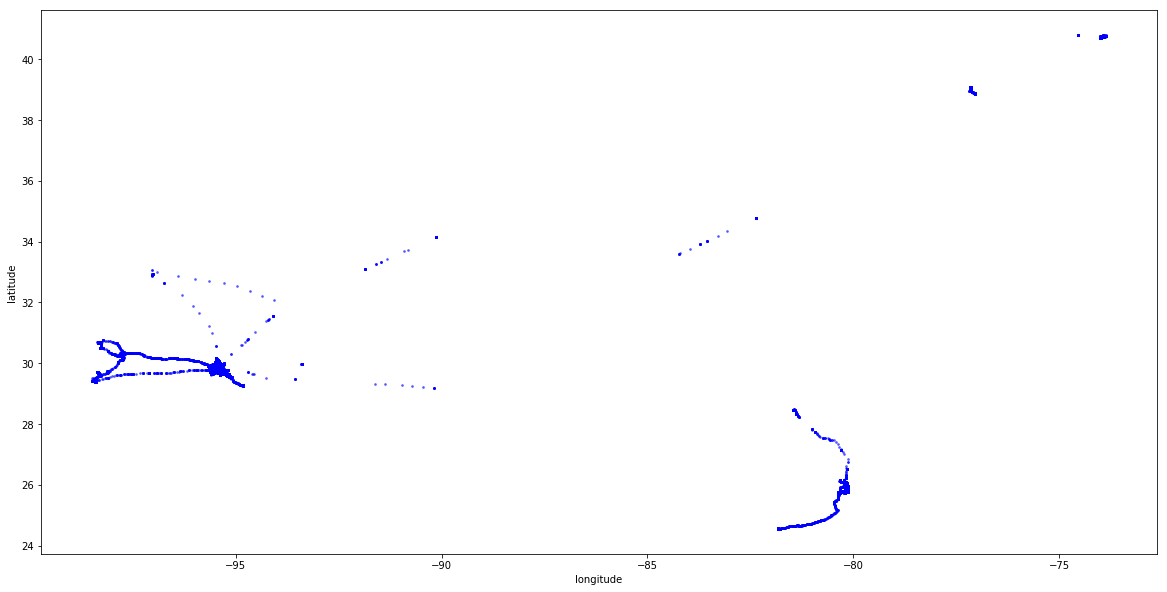

In [15]:
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df.longitude,df.latitude,c='blue',s=3,alpha=0.5)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')


Let's exclude flight GPS points

In [6]:
# recalculate miles differences
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

lat2 = df.latitude.values.tolist()
long2 = df.longitude.values.tolist()

lat1 = df.latitude.shift().values.tolist()
lat1[0] = lat2[0]
long1 = df.longitude.shift().values.tolist()
long1[0] = long2[0]

km_diff = haversine_array(lat1,long1,lat2,long2) 
df['mile_diff'] = km_diff * 0.621371 # to miles

In [10]:
df[df.mile_diff>12].groupby(['year','month','day']).mile_diff.mean()

year  month  day
2016  4      18      19.314191
      5      31     162.667397
      6      3      708.936381
      10     13     236.593397
      12     21      26.120457
             22     938.012779
             24     139.839309
             26      25.258437
             29      95.911094
2017  1      3      139.469908
Name: mile_diff, dtype: float64

In [11]:
df['plane'] = df.mile_diff>12

In [8]:
# df.to_feather(PATH/'houston_ready.feather')

In [12]:
df_ground = df[~df.plane].copy().reset_index(drop=True)

## Apply kmeans clustering

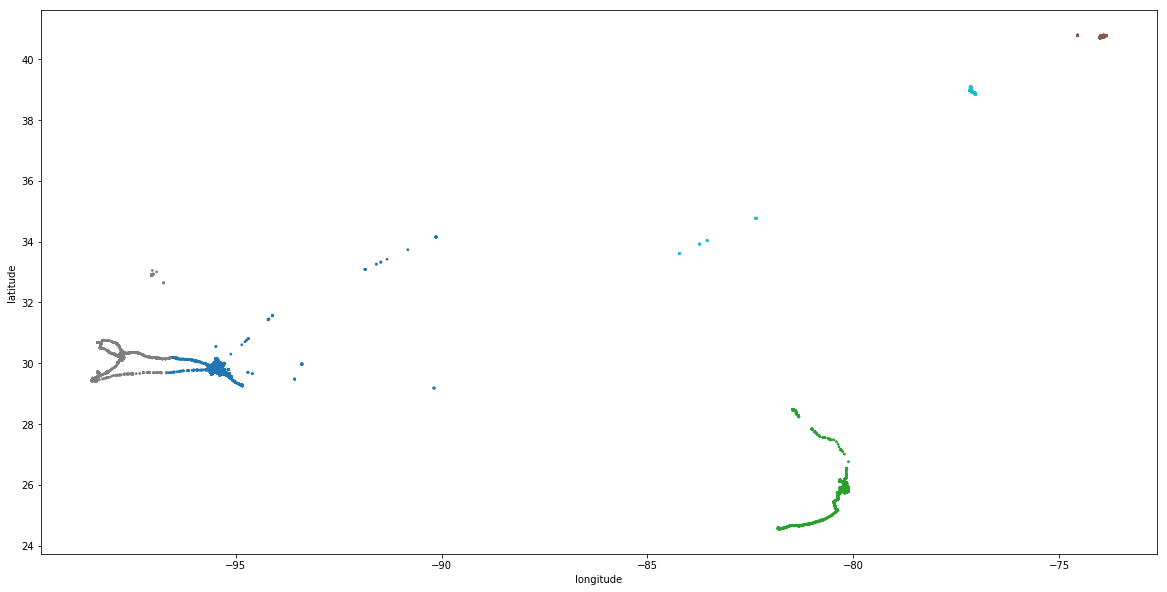

In [13]:
k=5
kmeans = KMeans(n_clusters=k,random_state=42).fit(df_ground[['latitude','longitude']])
df_ground['cluster']= kmeans.predict(df_ground[['latitude','longitude']])

fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_ground.longitude,df_ground.latitude,c=df_ground.cluster,cmap='tab10',s=3,alpha=1)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')


Look like we still have some residuals of flight GPS left. We did get rid most of flight GPS to Florida (bottom right) and around Dallas (above dense Houston points).

K-means did a good job on separate travelling points (outside of Houston). Let's plot each of them

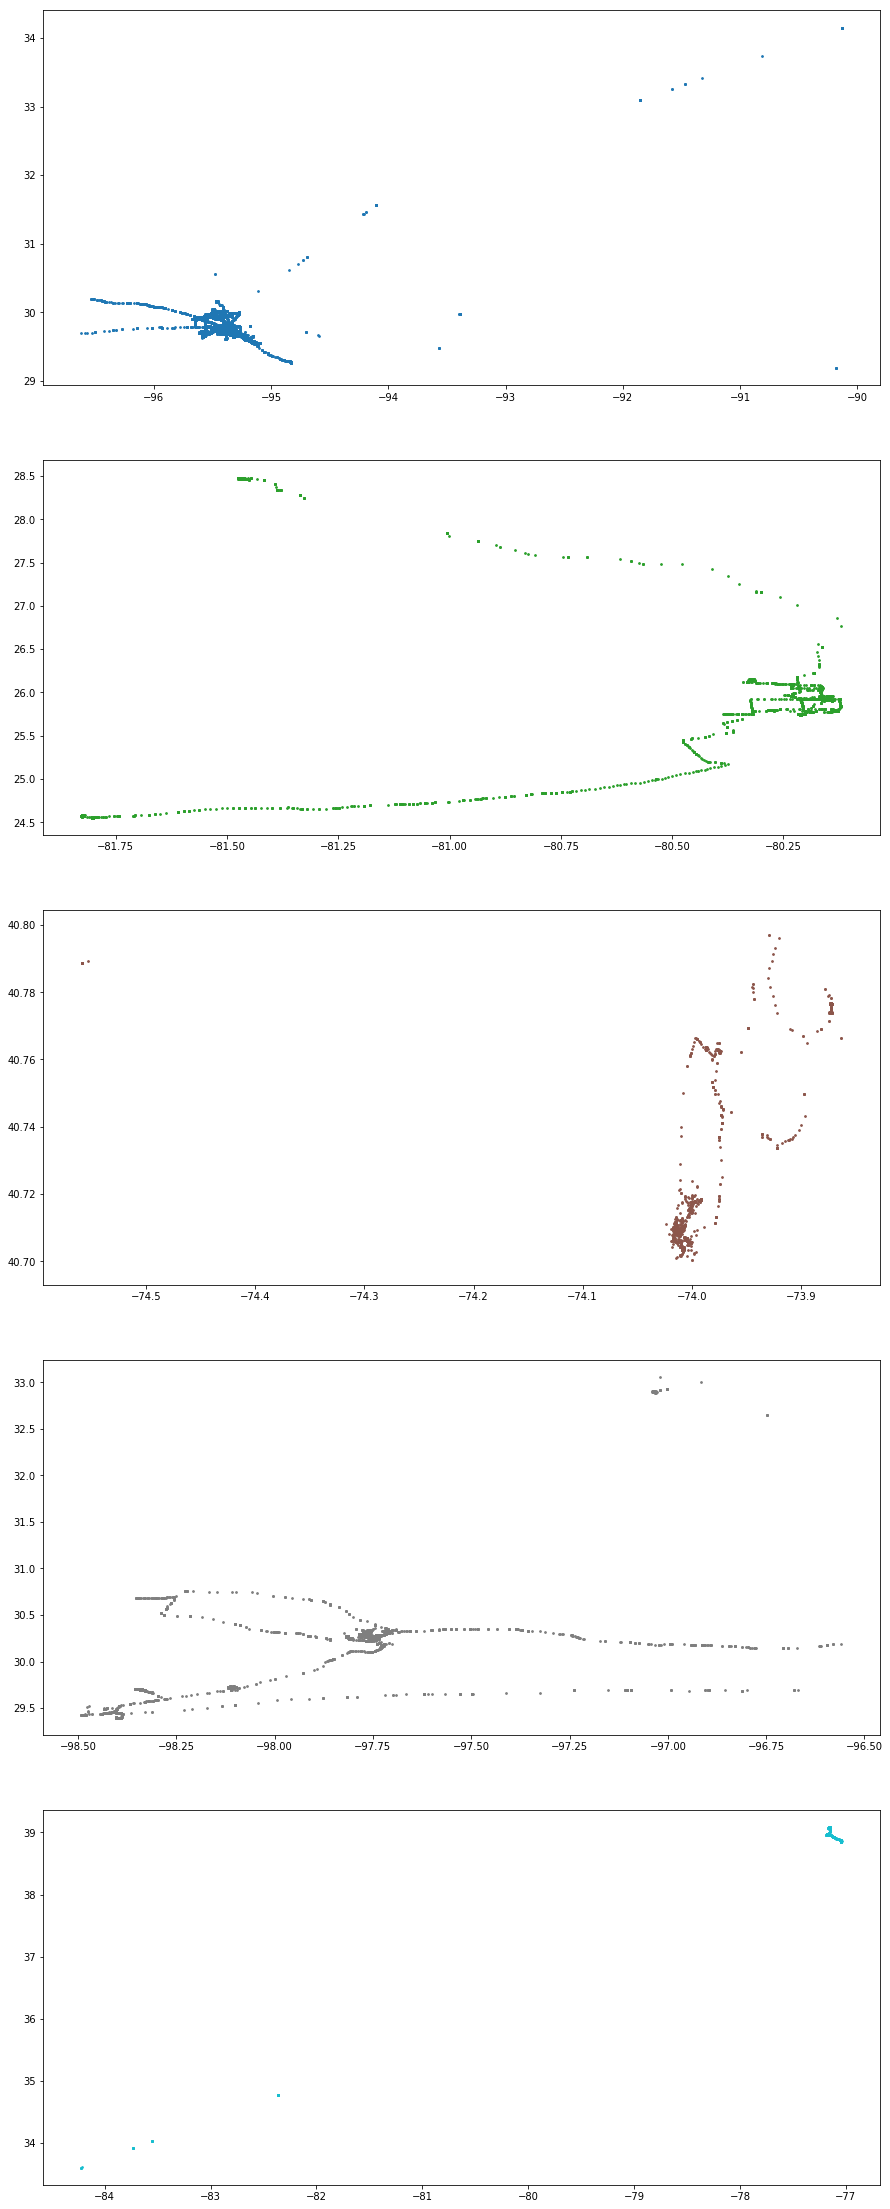

In [20]:
fig,axes = plt.subplots(nrows=k,figsize=(15,8*k));
for i in range(k):
    _=axes[i].scatter(df_ground[df_ground.cluster==i].longitude,df_ground[df_ground.cluster==i].latitude, c=colr_list[i],s=3,alpha=1)


After few k, k=5 seems to fit best as kmeans recognizes all the major states and cities I visited. Let's take a look at few of them

# Mapping GPS point with Folium

## cluster 1: Florida

In [11]:
df_flo = df_ground[df_ground.cluster==1].reset_index(drop=True)
df_flo.shape

(8830, 24)

In [93]:

callback = """\
function (row) {
    var icon, marker;
    icon = L.AwesomeMarkers.icon({
        icon: "map-marker", markerColor: "red"});
    marker = L.marker(new L.LatLng(row[0], row[1]));
    marker.setIcon(icon);
    return marker;
};
"""

In [14]:
FLORIDA=[26.492328,-80.497977]

                             
m_flo = folium.Map(location=FLORIDA,tiles='cartodbpositron',zoom_start=7)

FastMarkerCluster(data=list(zip(df_flo.latitude.values,df_flo.longitude.values)),
                 callback = callback).add_to(m_flo)

# for lat,long in zip(df_flo.latitude.values,df_flo.longitude.values):   
#     _=folium.CircleMarker([lat,long], radius=1,
#                     color='#0080bb', fill_color='#0080bb').add_to(m_flo);

folium.LayerControl().add_to(m_flo)

In [13]:
# m_flo.save(str(PATH/'florida.html'))

In [15]:
m_flo

## cluster 2: NY

In [16]:
df_ny = df_ground[df_ground.cluster==2].reset_index(drop=True)
df_ny.shape

(3165, 24)

In [19]:
NY=[40.735954,-73.993896]

                             
m_ny = folium.Map(location=NY,tiles='cartodbpositron',zoom_start=10)

FastMarkerCluster(data=list(zip(df_ny.latitude.values,df_ny.longitude.values)),
                 callback = callback).add_to(m_ny)

# for lat,long in zip(df_ny.latitude.values,df_ny.longitude.values):   
#     _=folium.CircleMarker([lat,long], radius=1,
#                     color='#0080bb', fill_color='#0080bb').add_to(m_ny);


folium.LayerControl().add_to(m_ny)

In [18]:
# m_ny.save(str(PATH/'ny.html'))

In [20]:
m_ny

## Cluster 3: Austin + San Antonio + Dallas

In [21]:
df_tx = df_ground[df_ground.cluster==3].reset_index(drop=True)
df_tx.shape

(7395, 24)

In [24]:
TX=[30.265253, -97.714187]

                             
m_tx = folium.Map(location=TX,tiles='cartodbpositron',zoom_start=7)

FastMarkerCluster(data=list(zip(df_tx.latitude.values,df_tx.longitude.values)),
                 callback = callback).add_to(m_tx)

# for lat,long in zip(df_tx.latitude.values,df_tx.longitude.values):   
#     _=folium.CircleMarker([lat,long], radius=1,
#                     color='#0080bb', fill_color='#0080bb').add_to(m_tx);


folium.LayerControl().add_to(m_tx)

In [23]:
# m_tx.save(str(PATH/'tx.html'))

In [25]:
m_tx

## Cluster 4: Maryland

In [26]:
df_md = df_ground[df_ground.cluster==4].reset_index(drop=True)
df_md.shape

(549, 24)

In [27]:
MD=[39.084967, -77.152883]

                             
m_md = folium.Map(location=MD,tiles='cartodbpositron',zoom_start=10)

FastMarkerCluster(data=list(zip(df_md.latitude.values,df_md.longitude.values)),
                 callback = callback).add_to(m_md)

# for lat,long in zip(df_tx.latitude.values,df_tx.longitude.values):   
#     _=folium.CircleMarker([lat,long], radius=1,
#                     color='#0080bb', fill_color='#0080bb').add_to(m_tx);


folium.LayerControl().add_to(m_md)

In [30]:
m_md

# Main target: hometown Houston

In [20]:
df_h = df_ground[df_ground.cluster==0].reset_index(drop=True)
df_h.shape

(321048, 24)

In [27]:
# plot fewer data points for folium
n=50000
idxs = np.random.permutation(len(df_h))[:n]

In [28]:
H=[29.766672, -95.339652]

                             
m_h = folium.Map(location=H,tiles='cartodbpositron',zoom_start=10)

FastMarkerCluster(data=list(zip(df_h.loc[idxs,:].latitude.values,df_h.loc[idxs,:].longitude.values)),
                 callback = callback).add_to(m_h)

# for lat,long in zip(df_h.latitude.values,df_h.longitude.values):   
#     _=folium.CircleMarker([lat,long], radius=1,
#                     color='#0080bb', fill_color='#0080bb').add_to(m_h);


folium.LayerControl().add_to(m_h)

In [33]:
# m_h.save(str(PATH/'houston.html'))

In [29]:
m_h

# Houston clustering

## Cleaning up

We will use kmeans to identify small cluster (traveling points and flight points) and exclude them

In [6]:
df_h = df_ground[(df_ground.cluster==0)].reset_index(drop=True)
df_h.shape

(321048, 24)

In [7]:
k=10
kmeans = KMeans(n_clusters=k,random_state=42).fit(df_h[['latitude','longitude']])
df_h['cluster']= kmeans.predict(df_h[['latitude','longitude']])

In [8]:
# drop cluster with < 500 points
temp = df_h.groupby('cluster').size()
drop_cluster = temp[temp<500].index.values
drop_cluster

array([2, 3, 6, 7, 8], dtype=int64)

In [9]:
df_lrg_cluster = df_h[~df_h.cluster.isin(drop_cluster)].reset_index(drop=True)

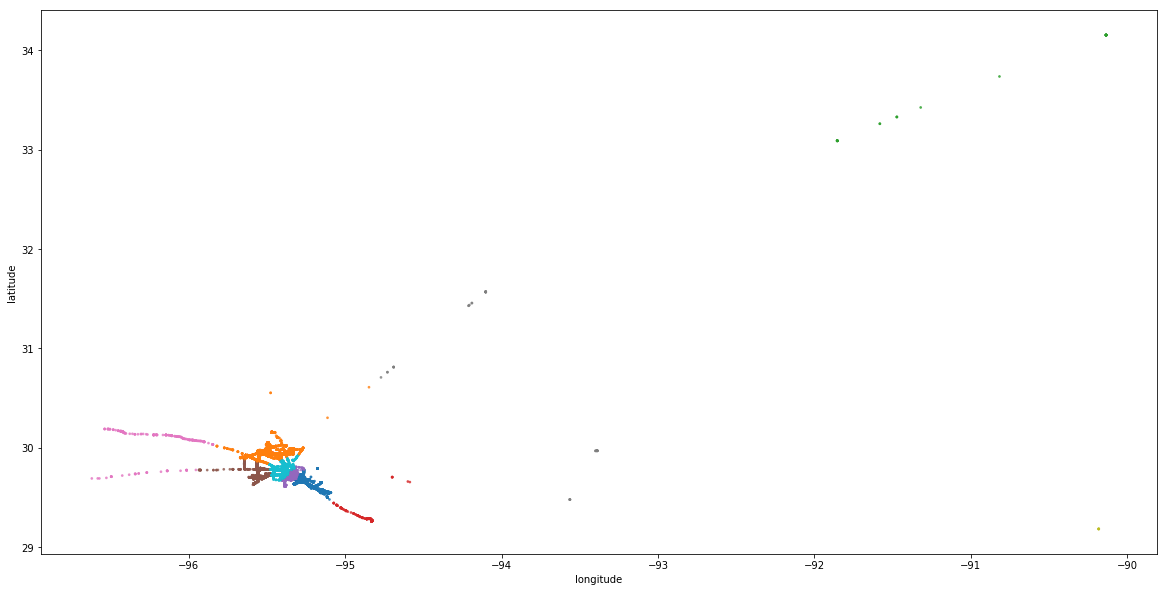

In [195]:
#before dropping small clusters
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_h.longitude,df_h.latitude,c=df_h.cluster,cmap='tab10',s=3,alpha=0.7)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

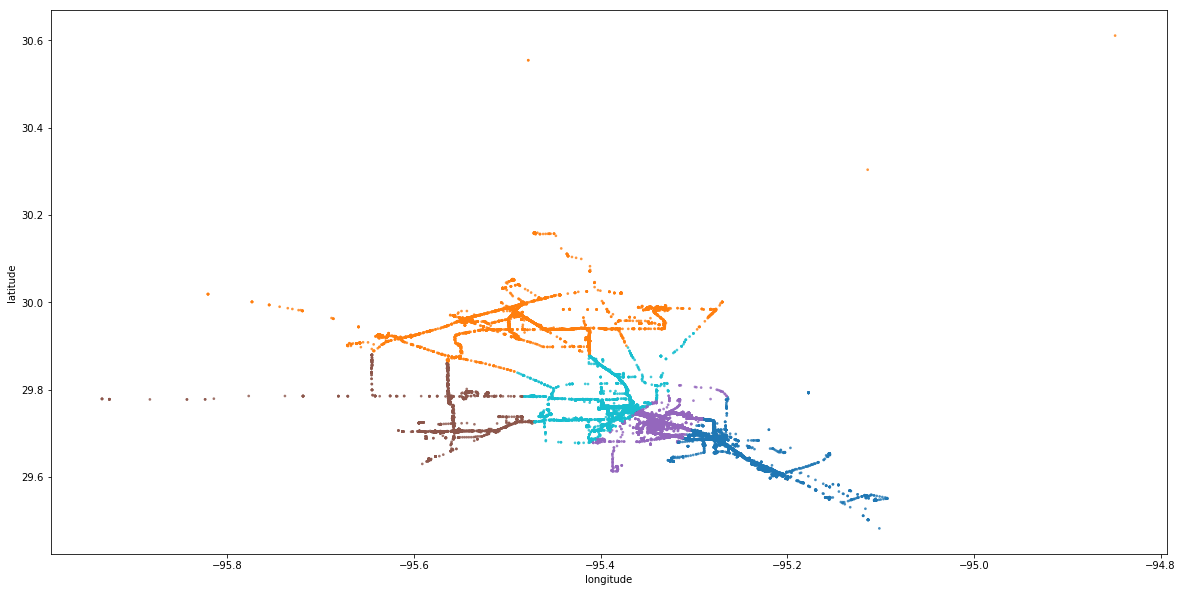

In [149]:
#after drop
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_lrg_cluster.longitude,df_lrg_cluster.latitude,c=df_lrg_cluster.cluster,cmap='tab10',s=3,alpha=0.7)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')


Looks much better now

### Excluding driving points (or at least less-traveled driving paths )

Driving paths can be annoying. Removing them will create gap between clusters thus make kmeans run more effectively. We will use speed and distance differences to identify driving points

In [10]:
date_shift = df_lrg_cluster.date_time.shift()
date_shift.loc[0] = df_lrg_cluster.date_time.loc[0]

df_lrg_cluster['sec_diff']=(df_lrg_cluster.date_time - date_shift).astype('timedelta64[s]')

In [11]:
df_lrg_cluster['speed'] =(df_lrg_cluster.mile_diff / df_lrg_cluster.sec_diff) * 3600 # to mph

In [12]:
df_lrg_cluster.speed.describe()

count    3.024320e+05
mean              inf
std               NaN
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.241693e-01
max               inf
Name: speed, dtype: float64

### Odd GPS points

In [13]:
temp = df_lrg_cluster[df_lrg_cluster.speed.isnull()] # both mile diff and second diff is 0
temp.shape


(17959, 26)

In [14]:
temp2=df_lrg_cluster[df_lrg_cluster.speed == np.inf] # mile diff !=0 but sec diff is 0
temp2.shape

(385, 26)

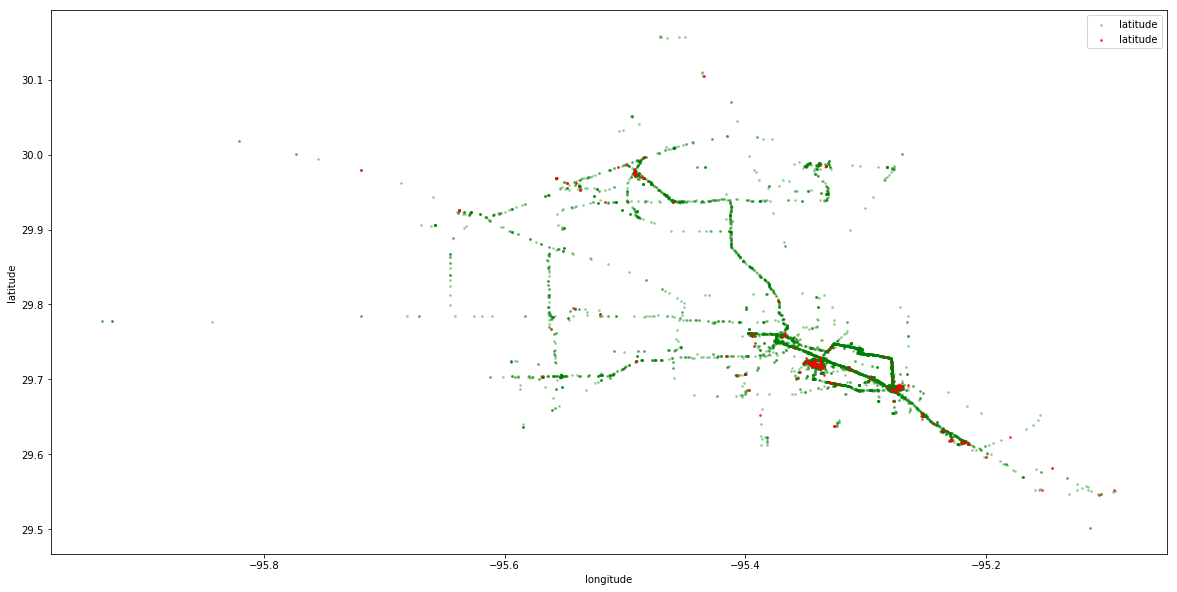

In [15]:
fig,ax = plt.subplots(figsize=(20,10))

# plot odd GPS points
_=ax.scatter(temp.longitude,temp.latitude,c='green',s=3,alpha=0.3)
_=ax.scatter(temp2.longitude,temp2.latitude,c='red',s=3,alpha=0.7)
_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')
_=ax.legend()

Lots of these odd GPS points resemble driving paths. We will remove them all

In [16]:
df_lrg_cluster.loc[df_lrg_cluster.speed == np.inf,'speed']=99 # treat as large speed (to be dropped)
df_lrg_cluster.loc[df_lrg_cluster.speed.isnull(),'speed']=99

In [17]:
df_lrg_cluster.speed.describe()

count    320391.000000
mean          9.762048
std          43.404268
min           0.000000
25%           0.000000
50%           0.002112
75%           0.423353
max        5858.795390
Name: speed, dtype: float64

In [ ]:
walk_spd=3.0 # in mph. Anything more than this speed will be considered as driving
max_dist=0.3 # limit distance between 2 GPS points. Any 2 points that exceed this will be considered as driving

In [19]:
# drop driving gps points
df_walking =df_lrg_cluster[(df_lrg_cluster.speed <= walk_spd) & (df_lrg_cluster.mile_diff <= max_dist)].copy().reset_index(drop=True) 
df_walking.shape

(270413, 26)

In [23]:
# clean up some outlier points
df_walking = df_walking[(df_walking.latitude < 30.2) & (df_walking.longitude > -95.7)].reset_index(drop=True)

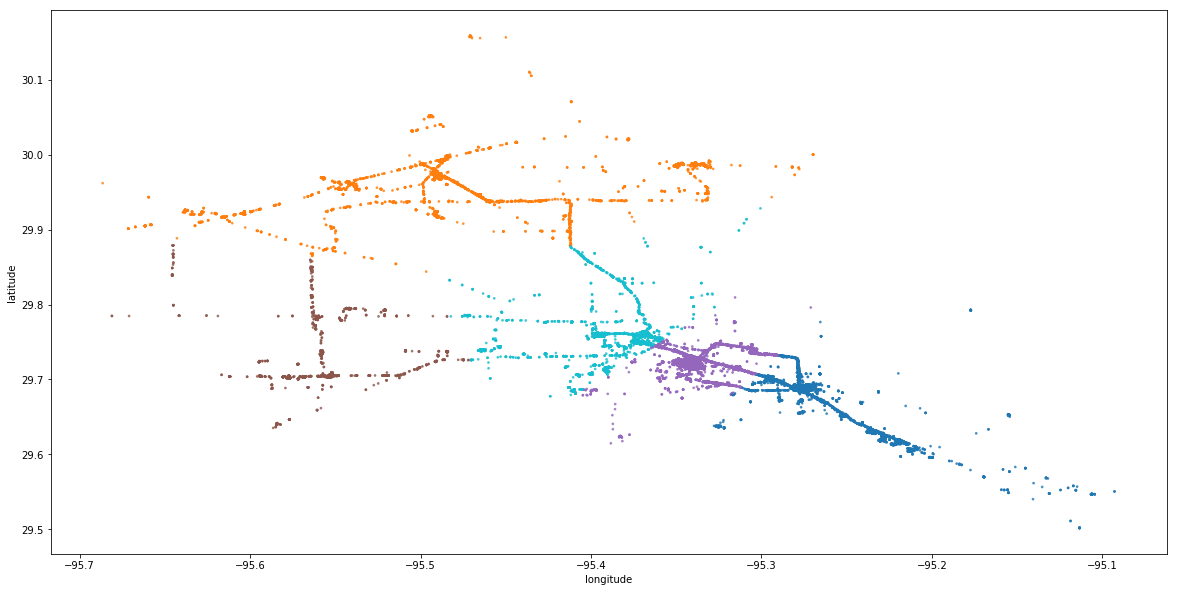

In [24]:
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_walking.longitude,df_walking.latitude,c=df_walking.cluster,cmap='tab10',s=3,alpha=0.7)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')


# Re-cluster Houston area

In [39]:
k=20
kmeans =KMeans(n_clusters=k,random_state=42,n_init=20).fit(df_walking[['latitude','longitude']])
df_walking['cluster']= kmeans.predict(df_walking[['latitude','longitude']])

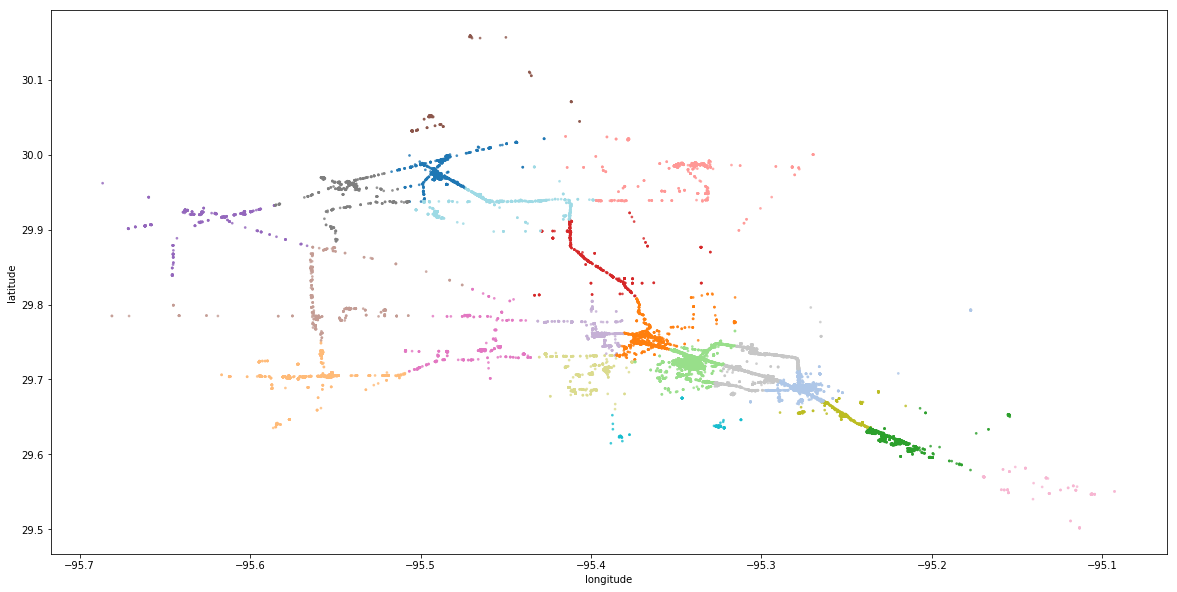

In [43]:
fig,ax = plt.subplots(figsize=(20,10))
_=ax.scatter(df_walking.longitude,df_walking.latitude,c=df_walking.cluster,cmap='tab20',s=3,alpha=0.7)

_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')

After some experiments with different k, few clusters still keep it shape. I decide to go with high k (20) so model can pick out common driving paths as well.

### Top 6 clusters

In [135]:
temp = df_walking.groupby('cluster').size()

In [154]:
temp.nlargest(n=6)

cluster
1     179550
0      32275
5      27338
9      10017
15      4215
4       3679
dtype: int64

In [155]:
idx_maxes=temp.nlargest(n=6).index.values

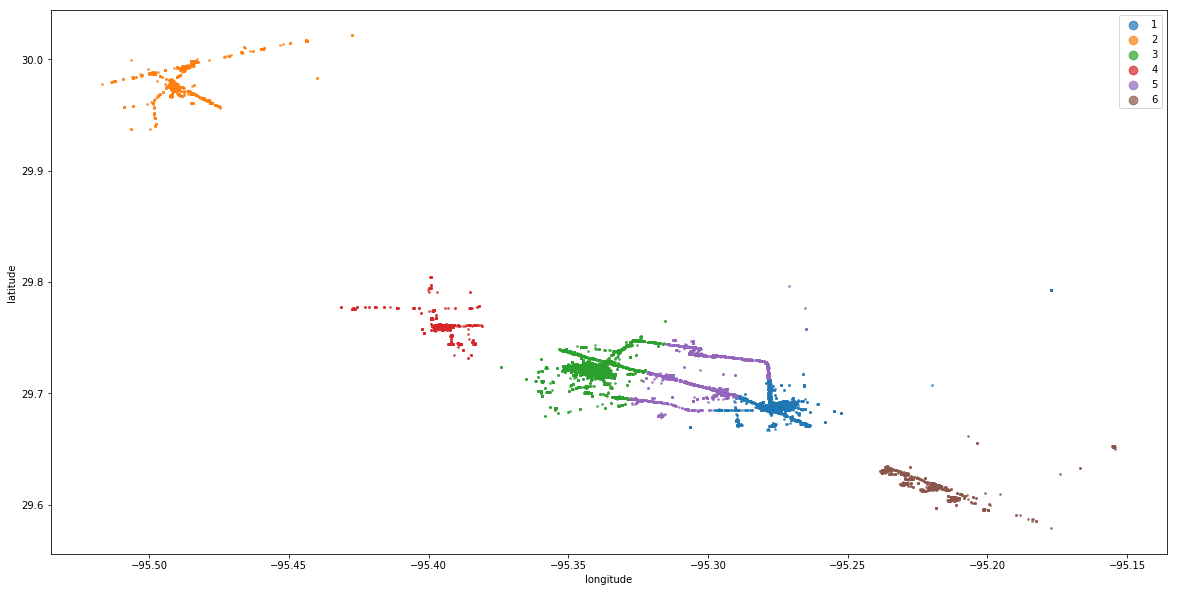

In [156]:
fig,ax = plt.subplots(figsize=(20,10))
for i,i_max in enumerate(idx_maxes):    
    _=ax.scatter(df_walking[df_walking.cluster==i_max].longitude,
                 df_walking[df_walking.cluster==i_max].latitude,cmap='tab10',s=3,alpha=0.7,label=f'{i+1}')
_=ax.set_ylabel('latitude')
_=ax.set_xlabel('longitude')
_=ax.legend(markerscale=5)

I can see my house area, my intern place, school and the usual supermarket + eat-out restaurants. The model also highlight my most-traveled roads from home to school. 

K-means did a good job on clustering both of my 'home' locations (the top two biggest clusters). One thing to notice is that the second biggest cluster (orange) is my other house I moved in at the end of my time in Texas. Even though I lived there for only 2 months, Google collects as much data from that place as my 'school' area (green) where I spent roughly 3 years attending college.

In [139]:
# H=[29.756397, -95.366300]
                             
# m_h = folium.Map(location=H,tiles='cartodbpositron',zoom_start=15)

# FastMarkerCluster(data=list(zip(df_walking[df_walking.cluster==idx_maxes[-1]].latitude.values,
#                  df_walking[df_walking.cluster==idx_maxes[-1]].longitude.values)),
#                  callback = callback).add_to(m_h)

# # for lat,long in zip(df_walking[df_walking.cluster==idx_maxes[3]].latitude.values,
# #                     df_walking[df_walking.cluster==idx_maxes[3]].longitude.values):   
# #     _=folium.CircleMarker([lat,long], radius=1,
# #                     color='#0080bb', fill_color='#0080bb').add_to(m_h);


# folium.LayerControl().add_to(m_h)

In [ ]:
# m_h

# Identify common habit

## Weekday vs Weekend

I will remove the 2nd home (the second biggest clusters) as I only lived there for a short amount of time

In [157]:
np.delete(idx_maxes,1)

array([ 1,  5,  9, 15,  4], dtype=int64)

In [158]:
df_lrg_cluster = df_walking[df_walking.cluster.isin(np.delete(idx_maxes,1))].copy().reset_index(drop=True)
df_lrg_cluster.shape

(224799, 26)

In [168]:
# weekend
df_lrg_cluster['is_weekend'] = ~df_lrg_cluster.day_of_week.isin(np.arange(0,5))

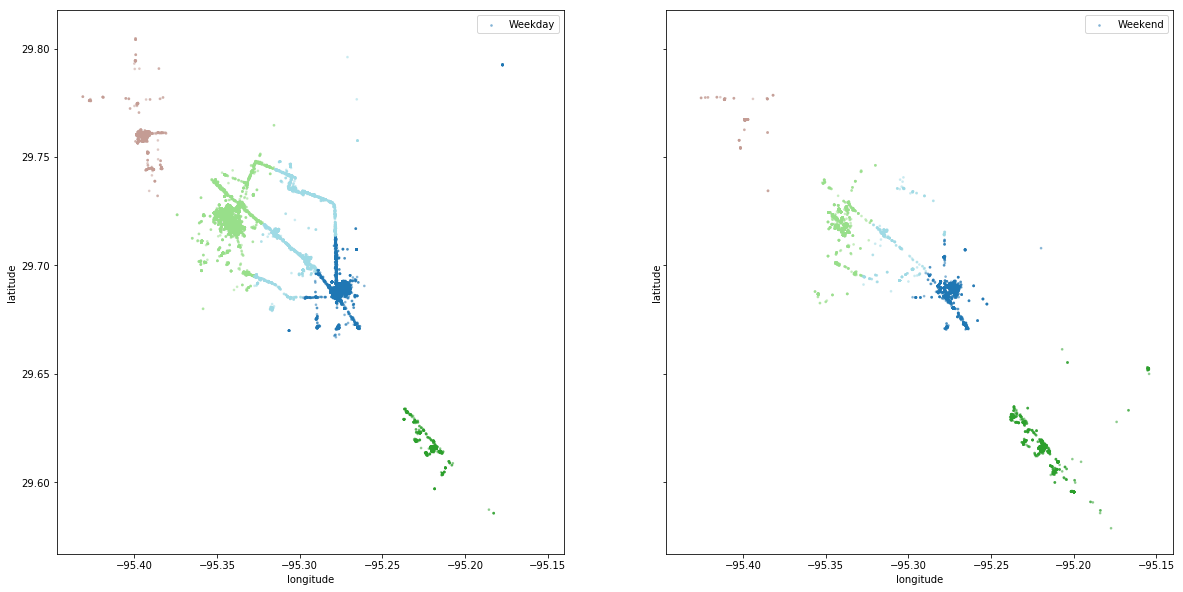

In [169]:
# weekday vs weekend

wd = df_lrg_cluster[~df_lrg_cluster.is_weekend]
we = df_lrg_cluster[df_lrg_cluster.is_weekend]
fig,axes = plt.subplots(ncols=2,figsize=(20,10),sharex=True,sharey=True)
_=axes[0].scatter(wd.longitude,
                 wd.latitude,c=wd.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekday')
_=axes[1].scatter(we.longitude,
                 we.latitude,c=we.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekend')
_=axes[0].set_ylabel('latitude')
_=axes[0].set_xlabel('longitude')
_=axes[0].legend()
_=axes[1].set_ylabel('latitude')
_=axes[1].set_xlabel('longitude')
_=axes[1].legend()

From here you can easily identify a Work cluster (it completely disappears in Weekend). That was where I did my 9-to-5 internship (during Summer). It's harder but you can still (kinda) identify school cluster as it reduces its size (I still went there in the weekend sometimes to work and study). There are 3 majors path from work to school, and you can see two of them faded in the weekend. These 2 paths are bus path and they had limited hours in the weekend. I mostly carpooled in the weekend, which results in the driving path not fading that much.

Bottom right cluster is probably the hardest to recognize. This is my supermarket/restaurants area and I came there more in the weekend to grab food (a bit denser and wider in the weekend graph)

## Day vs Night

In [196]:
# day-night
df_lrg_cluster['is_night'] = ~df_lrg_cluster.hour.isin(np.arange(9,20)) #day is from 9 am to 7:59 pm

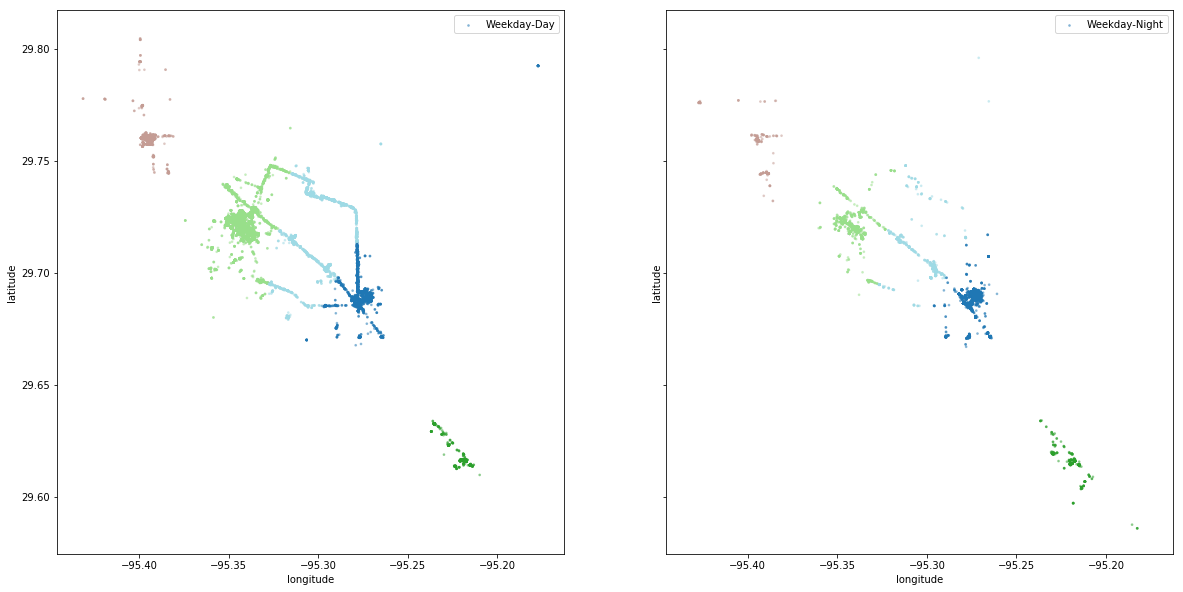

In [197]:
# weekday day vs night
wd_day = df_lrg_cluster[(~df_lrg_cluster.is_weekend) & (~df_lrg_cluster.is_night)]
wd_night = df_lrg_cluster[(~df_lrg_cluster.is_weekend) & (df_lrg_cluster.is_night)]

fig,axes = plt.subplots(ncols=2,figsize=(20,10),sharex=True,sharey=True)
_=axes[0].scatter(wd_day.longitude,
                 wd_day.latitude,c=wd_day.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekday-Day')
_=axes[1].scatter(wd_night.longitude,
                 wd_night.latitude,c=wd_night.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekday-Night')
_=axes[0].set_ylabel('latitude')
_=axes[0].set_xlabel('longitude')
_=axes[0].legend()
_=axes[1].set_ylabel('latitude')
_=axes[1].set_xlabel('longitude')
_=axes[1].legend()

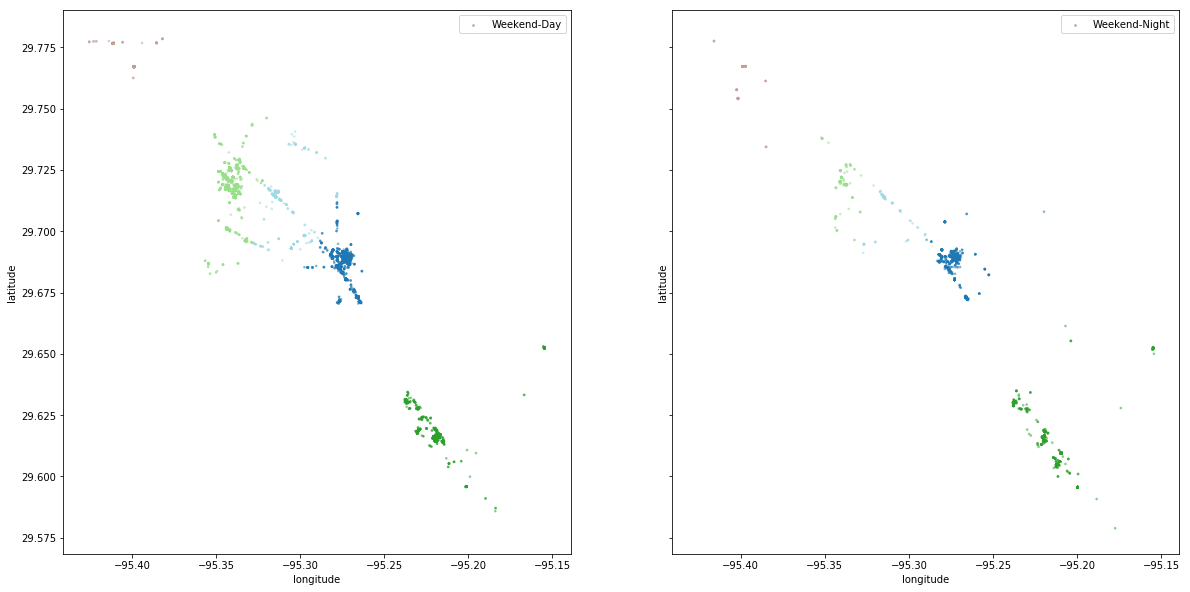

In [198]:
# weekend day vs night
we_day = df_lrg_cluster[(df_lrg_cluster.is_weekend) & (~df_lrg_cluster.is_night)]
we_night = df_lrg_cluster[(df_lrg_cluster.is_weekend) & (df_lrg_cluster.is_night)]

fig,axes = plt.subplots(ncols=2,figsize=(20,10),sharex=True,sharey=True)
_=axes[0].scatter(we_day.longitude,
                 we_day.latitude,c=we_day.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekend-Day')
_=axes[1].scatter(we_night.longitude,
                 we_night.latitude,c=we_night.cluster,cmap='tab20',s=3,alpha=0.4,label='Weekend-Night')
_=axes[0].set_ylabel('latitude')
_=axes[0].set_xlabel('longitude')
_=axes[0].legend()
_=axes[1].set_ylabel('latitude')
_=axes[1].set_xlabel('longitude')
_=axes[1].legend()

You can observe the similar pattern: work and school clusters are bigger at day and smaller at night. One interesting thing is in the supermarket/eat-out area, it has more variety in the night, especially in the weekend.


If you are really curious, you can do a day-by-day analysis to see more patterns of my Houston life. I am not sure whether I can do anything else with this dataset so I will stop here. Let me know if you have any suggestions on this dataset, and feel free to use your own dataset for this analysis,